In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input/concrete-crack-images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input/concrete-crack-images/images/crack-o-568.jpg
../input/concrete-crack-images/images/crack-o-389.jpg
../input/concrete-crack-images/images/crack-o-537.jpg
../input/concrete-crack-images/images/crack-o-457.jpg
../input/concrete-crack-images/images/crack-o-614.jpg
../input/concrete-crack-images/images/crack-o-90.jpg
../input/concrete-crack-images/images/crack-o-674.jpg
../input/concrete-crack-images/images/crack-o-170.jpg
../input/concrete-crack-images/images/crack-o-115.jpg
../input/concrete-crack-images/images/crack-o-480.jpg
../input/concrete-crack-images/images/crack-o-350.jpg
../input/concrete-crack-images/images/crack-o-390.jpg
../input/concrete-crack-images/images/crack-o-621.jpg
../input/concrete-crack-images/images/crack-o-500.jpg
../input/concrete-crack-images/images/crack-o-242.jpg
../input/concrete-crack-images/images/crack-o-159.jpg
../input/concrete-crack-images/images/crack-o-789.jpg
../input/concrete-crack-images/images/crack-o-67.jpg
../input/concrete-crack-images

# U-Net Original Research Paper
### Paper Name: U-Net: Convolutional Networks for Biomedical Image Segmentation
### Paper Link: https://arxiv.org/pdf/1505.04597.pdf

# Configs

In [2]:
class ROOTDIR:
    train = "../input/concrete-crack-images/images"
    train_mask = "../input/concrete-crack-images/masks"

# General Imports

In [3]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Extracting Files

dirs = ["../input/carvana-image-masking-challenge/train.zip",
        "../input/carvana-image-masking-challenge/train_masks.zip",
        "../input/carvana-image-masking-challenge/metadata.csv.zip"]

for i in tqdm(dirs):
    with zipfile.ZipFile(i) as z:
        z.extractall()
    

# Working with CSV

In [4]:
df = pd.read_csv("./metadata.csv")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: './metadata.csv'

In [ ]:
df.info()

# Working with Train Images and Masks

In [36]:
train_img_lst = os.listdir('../input/concrete-crack-images/images') # "./train"
train_mask_lst = os.listdir('../input/concrete-crack-images/masks') # "./train_masks"

In [37]:
print(train_mask_lst[:5])
print(train_img_lst[:5])

['crack-o-498.png', 'crack-o-382.png', 'crack-o-6.png', 'crack-o-723.png', 'crack-o-799.png']
['crack-o-568.jpg', 'crack-o-389.jpg', 'crack-o-537.jpg', 'crack-o-457.jpg', 'crack-o-614.jpg']


In [38]:
print(len(train_mask_lst))
print(len(train_img_lst))

800
800


#### Sorting to make sure we get right image and right mask

In [39]:
sorted_train_mask_lst = sorted(train_mask_lst)

In [40]:
sorted_train_img_lst = sorted(train_img_lst)

In [41]:
print(sorted_train_mask_lst[:16])
print(sorted_train_img_lst[:16])

['crack-o-1.png', 'crack-o-10.png', 'crack-o-100.png', 'crack-o-101.png', 'crack-o-102.png', 'crack-o-103.png', 'crack-o-104.png', 'crack-o-105.png', 'crack-o-106.png', 'crack-o-107.png', 'crack-o-108.png', 'crack-o-109.png', 'crack-o-11.png', 'crack-o-110.png', 'crack-o-111.png', 'crack-o-112.png']
['crack-o-1.jpg', 'crack-o-10.jpg', 'crack-o-100.jpg', 'crack-o-101.jpg', 'crack-o-102.jpg', 'crack-o-103.jpg', 'crack-o-104.jpg', 'crack-o-105.jpg', 'crack-o-106.jpg', 'crack-o-107.jpg', 'crack-o-108.jpg', 'crack-o-109.jpg', 'crack-o-11.jpg', 'crack-o-110.jpg', 'crack-o-111.jpg', 'crack-o-112.jpg']


# Visualizing Images with their Mask
### Making sure images and mask are paired correctly.

../input/concrete-crack-images/images/crack-o-1.jpg
(256, 256)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


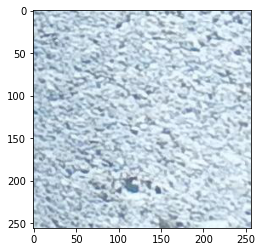

../input/concrete-crack-images/masks/crack-o-1.png
(256, 256)


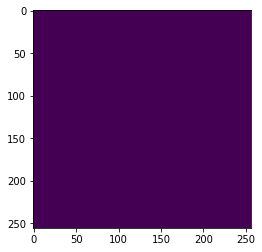

----------------------------------------------------
../input/concrete-crack-images/images/crack-o-10.jpg
(256, 256)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


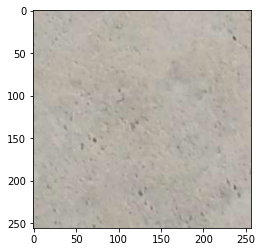

../input/concrete-crack-images/masks/crack-o-10.png
(256, 256)


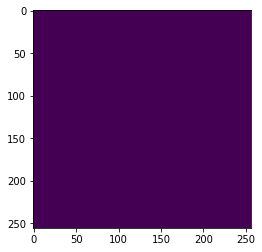

----------------------------------------------------


In [42]:
def show_images(imgs_lst,masks_lst,loops=2):
    for i in range(loops):
        img_path = os.path.join(ROOTDIR.train,imgs_lst[i])
        mask_path = os.path.join(ROOTDIR.train_mask,masks_lst[i])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

show_images(sorted_train_img_lst, sorted_train_mask_lst)

# PyTorch Imports

In [43]:
pwd

'/kaggle/working'

In [44]:
import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset

# PyTorch Configuration

In [45]:
class CFG:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    split_pct = 0.2
    learning_rate = 3e-4
    batch_size = 4
    epochs = 10

In [46]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

In [47]:
CFG.device

device(type='cuda')

# Working with data

### Shuffling the data.

In [48]:
#permuted_train_img_lst = np.random.permutation(np.array(sorted_train_img_lst))
#permuted_train_mask_lst = [x.replace(".jpg", "_mask.gif") for x in permuted_train_img_lst]
permuted_train_img_lst=sorted_train_img_lst
permuted_train_mask_lst=sorted_train_mask_lst
print(permuted_train_img_lst[:5])
print(permuted_train_mask_lst[:5])

['crack-o-1.jpg', 'crack-o-10.jpg', 'crack-o-100.jpg', 'crack-o-101.jpg', 'crack-o-102.jpg']
['crack-o-1.png', 'crack-o-10.png', 'crack-o-100.png', 'crack-o-101.png', 'crack-o-102.png']


../input/concrete-crack-images/images/crack-o-1.jpg
(256, 256)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


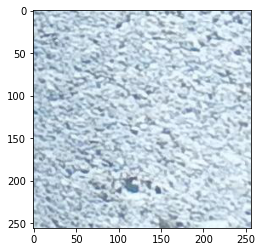

../input/concrete-crack-images/masks/crack-o-1.png
(256, 256)


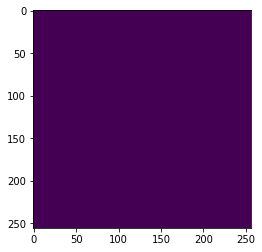

----------------------------------------------------
../input/concrete-crack-images/images/crack-o-10.jpg
(256, 256)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


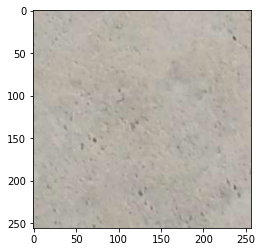

../input/concrete-crack-images/masks/crack-o-10.png
(256, 256)


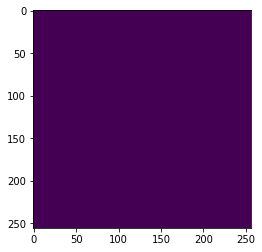

----------------------------------------------------


In [49]:
show_images(permuted_train_img_lst,permuted_train_mask_lst)

### Splitting into Training and Validation

In [50]:
length = len(permuted_train_img_lst)
print(length*0.2) # convert this to int

160.0


In [51]:
train_images_list = permuted_train_img_lst[int(CFG.split_pct*len(permuted_train_img_lst)) :]
train_masks_list = permuted_train_mask_lst[int(CFG.split_pct*len(permuted_train_mask_lst)) :]
print(len(train_masks_list))

val_images_list = permuted_train_img_lst[: int(CFG.split_pct*len(permuted_train_img_lst))]
val_masks_list = permuted_train_mask_lst[: int(CFG.split_pct*len(permuted_train_mask_lst))]
print(len(val_masks_list))

# 4071+1017=5088 (split includes all items)

640
160


### Visualizing Train Dataset

../input/concrete-crack-images/images/crack-o-243.jpg
(256, 256)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


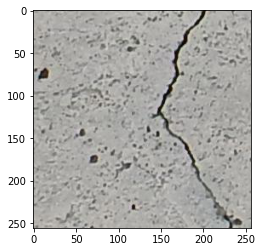

../input/concrete-crack-images/masks/crack-o-243.png
(256, 256)


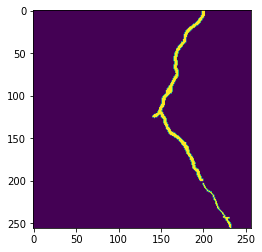

----------------------------------------------------
../input/concrete-crack-images/images/crack-o-244.jpg
(256, 256)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


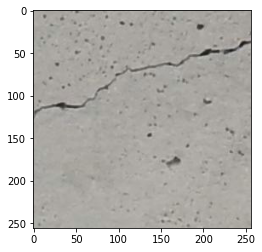

../input/concrete-crack-images/masks/crack-o-244.png
(256, 256)


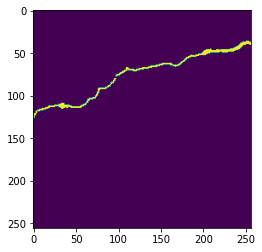

----------------------------------------------------


In [52]:
show_images(train_images_list,train_masks_list)

### Visualizing Validation Dataset

../input/concrete-crack-images/images/crack-o-1.jpg
(256, 256)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


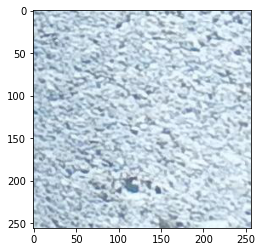

../input/concrete-crack-images/masks/crack-o-1.png
(256, 256)


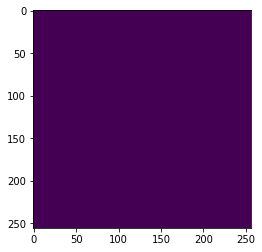

----------------------------------------------------
../input/concrete-crack-images/images/crack-o-10.jpg
(256, 256)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


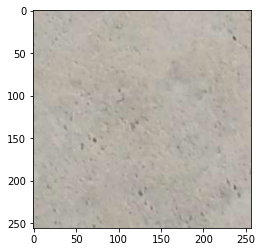

../input/concrete-crack-images/masks/crack-o-10.png
(256, 256)


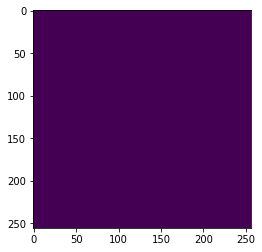

----------------------------------------------------


In [53]:
show_images(val_images_list,val_masks_list)

# Dataset Class

In [54]:
class CarvanaDataset(Dataset):
    def __init__(self,img_list,mask_list,transform=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,index):
        img_path = os.path.join(ROOTDIR.train,self.img_list[index])
        mask_path = os.path.join(ROOTDIR.train_mask,self.mask_list[index])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0
        #img_mask_dict = {"image": img, "mask": mask}
        
        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)
            #transformations = self.transform(image=img, mask=mask)
            #img = transformations["image"]
            #mask = transformations["mask"]
            
        return img,mask

In [55]:
train_transform = A.Compose([A.Resize(572,572), 
                             A.Rotate(limit=15,p=0.1),
                             A.HorizontalFlip(p=0.5),
                             A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(572,572),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [56]:
train_dataset = CarvanaDataset(train_images_list, train_masks_list, transform = train_transform)
val_dataset = CarvanaDataset(val_images_list, val_masks_list, transform = train_transform)

In [57]:
idx = 200
img,mask = train_dataset[idx]

In [58]:
mask.shape

torch.Size([1, 572, 572])

In [59]:
img.max()

tensor(0.8549)

In [60]:
def show_single_img(img,mask,index=None,train=True):
    if index:
        if train:
            img,mask = train_dataset[index]
        else:
            img,mask = val_dataset[index]
    plt.imshow(img.permute(1,2,0),cmap="gray")  # Convert (3, 572, 572) -> (572, 572, 3)
    plt.show()
    plt.imshow(mask.permute(1,2,0), cmap="gray")  # Convert (1, 572, 572) -> (572, 572, 1)
    print(mask.shape)
    plt.show()
    

---------------Train---------------


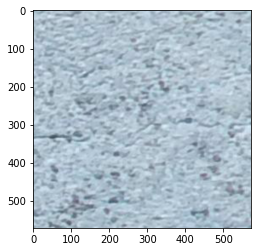

torch.Size([1, 572, 572])


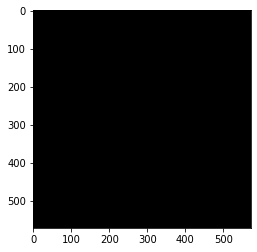

---------------Validation---------------


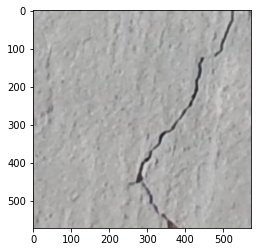

torch.Size([1, 572, 572])


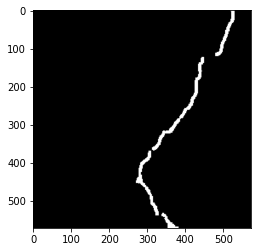

In [61]:
print("---------------Train---------------")
show_single_img(img,mask,index=15,train=False)
print("---------------Validation---------------")
show_single_img(img,mask,index=15,train=True)

# Dataloader

In [62]:
train_dataloader = DataLoader(train_dataset,batch_size=CFG.batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=CFG.batch_size,shuffle=False)

In [63]:
a = iter(train_dataloader)
img,mask = a.next()
print(img.shape,mask.shape)

torch.Size([4, 3, 572, 572]) torch.Size([4, 1, 572, 572])


### Utility Functions

In [64]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv

#def cropper(og_tensor, target_tensor):
#    og_shape = og_tensor.shape[2]
#    target_shape = target_tensor.shape[2]
#    delta = (og_shape - target_shape) // 2
#    cropped_og_tensor = og_tensor[:,:,delta:og_shape-delta,delta:og_shape-delta]
#    return cropped_og_tensor
 
    
def padder(left_tensor, right_tensor): 
    # left_tensor is the tensor on the encoder side of UNET
    # right_tensor is the tensor on the decoder side  of the UNET
    
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(CFG.device)
    
    return right_tensor.to(CFG.device)
    

# UNET MODEL FROM SCRATCH

In [65]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        #print(self.down_conv_1)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)
        
    def forward(self,x):
        
        # encoding
        x1 = self.down_conv_1(x)
        #print("X1", x1.shape)
        p1 = self.max_pool(x1)
        #print("p1", p1.shape)
        x2 = self.down_conv_2(p1)
        #print("X2", x2.shape)
        p2 = self.max_pool(x2)
        #print("p2", p2.shape)
        x3 = self.down_conv_3(p2)
        #print("X2", x3.shape)
        p3 = self.max_pool(x3)
        #print("p3", p3.shape)
        x4 = self.down_conv_4(p3)
        #print("X4", x4.shape)
        p4 = self.max_pool(x4)
        #print("p4", p4.shape)
        x5 = self.down_conv_5(p4)
        #print("X5", x5.shape)
        
        # decoding
        d1 = self.up_conv_trans_1(x5)  # up transpose convolution ("up sampling" as called in UNET paper)
        pad1 = padder(x4,d1) # padding d1 to match x4 shape
        cat1 = torch.cat([x4,pad1],dim=1) # concatenating padded d1 and x4 on channel dimension(dim 1) [batch(dim 0),channel(dim 1),height(dim 2),width(dim 3)]
        uc1 = self.up_conv_1(cat1) # 1st up double convolution
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1
        #print(conv_1x1.shape)

# Training and Validation

### Train Function


In [66]:
def train_model(model,dataloader,criterion,optimizer):
    model.train()
    train_running_loss = 0.0
    for j,img_mask in enumerate(tqdm(dataloader)):
        img = img_mask[0].float().to(CFG.device)
        #print(" ----- IMAGE -----")
        #print(img)
        mask = img_mask[1].float().to(CFG.device)
        #print(" ----- MASK -----")
        #print(mask)
        
        y_pred = model(img)
        #print(" ----- Y PRED -----")
        #print(y_pred)
        #print(" ----- Y PRED SHAPE -----")#
        #print(y_pred.shape)
        optimizer.zero_grad()
        
        loss = criterion(y_pred,mask)
        
        train_running_loss += loss.item() * CFG.batch_size
        
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / (j+1)
    return train_loss

### Validation Function

In [67]:
def val_model(model,dataloader,criterion,optimizer):
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for j,img_mask in enumerate(tqdm(dataloader)):
            img = img_mask[0].float().to(CFG.device)
            mask = img_mask[1].float().to(CFG.device)
            y_pred = model(img)
            loss = criterion(y_pred,mask)
            
            val_running_loss += loss.item() * CFG.batch_size
            
        val_loss = val_running_loss / (j+1)
    return val_loss

In [68]:
model = UNET(in_chnls = 3, n_classes = 1).to(CFG.device)
optimizer = optim.Adam(model.parameters(), lr = CFG.learning_rate)
criterion = nn.BCEWithLogitsLoss()
train_loss_lst = []
val_loss_lst = []  

### Train and Validation Loop

In [69]:
for i in tqdm(range(CFG.epochs)):
    train_loss = train_model(model=model,dataloader=train_dataloader,criterion=criterion,optimizer=optimizer)
    val_loss = val_model(model=model,dataloader=val_dataloader,criterion=criterion,optimizer=optimizer)
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)
    print(f" Train Loss : {train_loss:.4f}")
    print(f" Validation Loss : {val_loss:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

 Train Loss : -65.9111
 Validation Loss : -128.9245


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

 Train Loss : -120.4113
 Validation Loss : -161.4694


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

 Train Loss : -181.8676
 Validation Loss : -226.0963


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

 Train Loss : -255.8090
 Validation Loss : -307.6474


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

 Train Loss : -340.3367
 Validation Loss : -625.6272


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

 Train Loss : -416.8941
 Validation Loss : -569.3373


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

 Train Loss : -527.3206
 Validation Loss : -410.5517


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

 Train Loss : -639.0968
 Validation Loss : -1588.4907


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

 Train Loss : -738.9350
 Validation Loss : -1329.6471


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

 Train Loss : -849.3909
 Validation Loss : -1033.7036


### Training and Validation Loss Plot

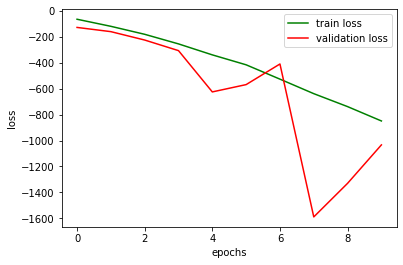

In [70]:
plt.plot(train_loss_lst, color="green", label='train loss')
plt.plot(val_loss_lst, color="red", label='validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

# Saving Model

In [71]:
TRAINED_FILE = "/kaggle/working/unet_scratch.pth"

In [72]:
torch.save(model.state_dict(), TRAINED_FILE)

In [73]:
from IPython.display import FileLink
FileLink(TRAINED_FILE)

/kaggle/working/unet_scratch.pth

# Testing

In [74]:
trained_model = UNET(in_chnls = 3, n_classes = 1)

In [75]:
UNET_TRAINED = "/kaggle/working/unet_scratch.pth"

In [76]:
trained_model.load_state_dict(torch.load(UNET_TRAINED))

<All keys matched successfully>

In [77]:
trained_model = trained_model.to("cuda")
trained_model.eval()


UNET(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=

In [78]:
img_path = "/kaggle/input/testimg/123.jpeg"

img = cv2.imread(img_path)

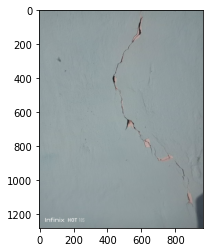

In [79]:
plt.imshow(img)
plt.show()

In [80]:
test_transform = A.Compose([A.Resize(572,572),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [81]:
test_image = test_transform(image = img)

print(test_image)

print(test_image["image"].dtype)
print(test_image["image"].shape)

img = test_image["image"].unsqueeze(0)
print(img.shape)

img = img.to("cuda")

{'image': tensor([[[0.5373, 0.5412, 0.5451,  ..., 0.4941, 0.4902, 0.4863],
         [0.5373, 0.5412, 0.5451,  ..., 0.4941, 0.4863, 0.4824],
         [0.5373, 0.5412, 0.5451,  ..., 0.4902, 0.4824, 0.4784],
         ...,
         [0.5137, 0.5137, 0.5137,  ..., 0.2157, 0.2157, 0.2157],
         [0.5137, 0.5137, 0.5137,  ..., 0.2157, 0.2157, 0.2157],
         [0.5137, 0.5137, 0.5137,  ..., 0.2157, 0.2157, 0.2157]],

        [[0.5765, 0.5804, 0.5804,  ..., 0.5451, 0.5412, 0.5373],
         [0.5765, 0.5804, 0.5843,  ..., 0.5451, 0.5373, 0.5333],
         [0.5765, 0.5804, 0.5843,  ..., 0.5373, 0.5333, 0.5294],
         ...,
         [0.5647, 0.5647, 0.5647,  ..., 0.2549, 0.2549, 0.2549],
         [0.5647, 0.5647, 0.5647,  ..., 0.2549, 0.2549, 0.2549],
         [0.5647, 0.5647, 0.5647,  ..., 0.2549, 0.2549, 0.2549]],

        [[0.5765, 0.5804, 0.5804,  ..., 0.5529, 0.5490, 0.5451],
         [0.5765, 0.5804, 0.5843,  ..., 0.5490, 0.5451, 0.5412],
         [0.5765, 0.5804, 0.5843,  ..., 0.5490, 

In [82]:
pred = trained_model(img)
pred.shape

torch.Size([1, 1, 572, 572])

In [83]:
mask = pred.squeeze(0).cpu().detach().numpy()
print(mask.shape)
mask = mask.transpose(1,2,0)
print(mask.shape)

(1, 572, 572)
(572, 572, 1)


In [84]:
display_test_img = test_image["image"].cpu().detach().numpy()
print(display_test_img.shape)
display_test_img = display_test_img.transpose(1,2,0)
display_test_img.shape

(3, 572, 572)


(572, 572, 3)

In [85]:
mask[mask < 0]=0
mask[mask > 0]=1

-------Original Image-------


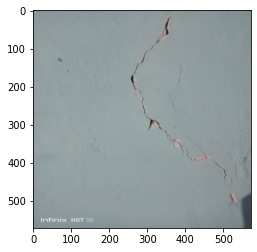

-------Image Mask-------


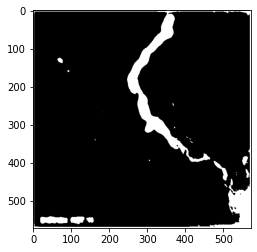

In [86]:
print("-------Original Image-------")
plt.imshow(display_test_img, cmap="gray")
plt.show()
print("-------Image Mask-------")
plt.imshow(mask,cmap="gray")
plt.show()